<a href="https://colab.research.google.com/github/aryamaddel/Tsunami-Prediction/blob/main/Tsunami%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tsunami Prediction Model

This notebook builds a machine learning model to predict tsunamis based on historical data. We'll analyze various features like earthquake magnitude, location, and other geological factors to predict tsunami occurrence and characteristics.

## Dataset Overview

The dataset contains historical tsunami events with various features including:

- Earthquake magnitude and location
- Tsunami characteristics (height, magnitude, intensity)
- Geographic information (latitude, longitude, country)
- Impact data (deaths, damage, houses affected)


In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Sklearn for preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)
from sklearn.impute import SimpleImputer

import warnings

warnings.filterwarnings("ignore")

# Set up plotting parameters
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 8)
sns.set_palette("husl")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [14]:
# Load the tsunami dataset
df = pd.read_csv("tsunami.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {len(df.columns)}")
print("\nColumn names:")
print(df.columns.tolist())

# Display basic info about the dataset
print(f"\nDataset Info:")
print(f"- Total records: {len(df)}")
print(f"- Total columns: {len(df.columns)}")

# Check for missing values in key columns
key_columns = [
    "Year",
    "Earthquake Magnitude",
    "Latitude",
    "Longitude",
    "Maximum Water Height (m)",
    "Tsunami Magnitude (Abe)",
    "Tsunami Intensity",
]
print(f"\nMissing values in key columns:")
for col in key_columns:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        print(f"- {col}: {missing_count} ({missing_pct:.1f}%)")

# Display sample data
print("\nSample data:")
sample_cols = [
    "Year",
    "Earthquake Magnitude",
    "Latitude",
    "Longitude",
    "Maximum Water Height (m)",
    "Tsunami Magnitude (Abe)",
    "Tsunami Intensity",
]
available_cols = [col for col in sample_cols if col in df.columns]
print(df[available_cols].head(10))


Dataset shape: (2381, 19)

Columns: 19

Column names:
['Year', 'Mo', 'Dy', 'Hr', 'Mn', 'Sec', 'Tsunami Event Validity', 'Tsunami Cause Code', 'Earthquake Magnitude', 'Vol', 'Country', 'Location Name', 'Latitude', 'Longitude', 'Maximum Water Height (m)', 'Number of Runups', 'Tsunami Magnitude (Abe)', 'Tsunami Magnitude (Iida)', 'Tsunami Intensity']

Dataset Info:
- Total records: 2381
- Total columns: 19

Missing values in key columns:
- Year: 0 (0.0%)
- Earthquake Magnitude: 960 (40.3%)
- Latitude: 295 (12.4%)
- Longitude: 295 (12.4%)
- Maximum Water Height (m): 1113 (46.7%)
- Tsunami Magnitude (Abe): 2379 (99.9%)
- Tsunami Intensity: 1475 (61.9%)

Sample data:
   Year  Earthquake Magnitude  Latitude  Longitude  Maximum Water Height (m)  \
0  1800                   NaN       NaN        NaN                       NaN   
1  1802                   NaN      45.3       14.4                       NaN   
2  1802                   NaN      17.2      -62.4                       NaN   
3  1802   

In [15]:
# Data Preprocessing and Feature Engineering
print("=== Data Preprocessing ===")

# Create a copy for preprocessing
df_processed = df.copy()

# Convert year to numeric and filter for modern data (after 1900 for better quality)
df_processed["Year"] = pd.to_numeric(df_processed["Year"], errors="coerce")
df_processed = df_processed[df_processed["Year"] >= 1900].copy()

print(f"After filtering modern data (>= 1900): {len(df_processed)} records")

# Key features for prediction (updated to match your trimmed dataset)
feature_columns = [
    "Year",
    "Mo",
    "Dy",
    "Hr",
    "Mn",
    "Sec",
    "Tsunami Event Validity",
    "Tsunami Cause Code",
    "Earthquake Magnitude",
    "Vol",
    "Latitude",
    "Longitude",
    "Maximum Water Height (m)",
    "Number of Runups",
    "Tsunami Magnitude (Abe)",
    "Tsunami Magnitude (Iida)",
    "Tsunami Intensity",
]

# Check which columns exist
existing_features = [col for col in feature_columns if col in df_processed.columns]
print(f"\nAvailable feature columns: {existing_features}")


# Create target variables
# 1. Tsunami Severity Classification (based on water height and intensity)
def classify_tsunami_severity(row):
    """Classify tsunami severity based on multiple factors"""
    water_height = row.get("Maximum Water Height (m)", 0)
    intensity = row.get("Tsunami Intensity", 0)

    # Handle NaN values
    water_height = 0 if pd.isna(water_height) else water_height
    intensity = 0 if pd.isna(intensity) else intensity

    # Classification logic (adjusted since we don't have deaths/damage data)
    if water_height >= 10 or intensity >= 5:
        return 3  # Extreme
    elif water_height >= 5 or intensity >= 4:
        return 2  # Major
    elif water_height >= 2 or intensity >= 3:
        return 1  # Moderate
    else:
        return 0  # Minor


df_processed["Tsunami_Severity"] = df_processed.apply(classify_tsunami_severity, axis=1)

# 2. Binary classification: High vs Low intensity (since we don't have damage data)
df_processed["Is_High_Intensity"] = (
    (df_processed["Maximum Water Height (m)"].fillna(0) >= 2)
    | (df_processed["Tsunami Intensity"].fillna(0) >= 3)
).astype(int)

print(f"\nTarget variable distributions:")
print(f"Tsunami Severity (0=Minor, 1=Moderate, 2=Major, 3=Extreme):")
print(df_processed["Tsunami_Severity"].value_counts().sort_index())
print(f"\nHigh Intensity Tsunamis (0=Low, 1=High):")
print(df_processed["Is_High_Intensity"].value_counts().sort_index())

# Display sample of processed data
print(f"\nProcessed data sample:")
display_cols = [
    "Year",
    "Earthquake Magnitude",
    "Latitude",
    "Longitude",
    "Maximum Water Height (m)",
    "Tsunami Intensity",
    "Tsunami_Severity",
    "Is_High_Intensity",
]
available_display_cols = [col for col in display_cols if col in df_processed.columns]
print(df_processed[available_display_cols].head(10))


=== Data Preprocessing ===
After filtering modern data (>= 1900): 1591 records

Available feature columns: ['Year', 'Mo', 'Dy', 'Hr', 'Mn', 'Sec', 'Tsunami Event Validity', 'Tsunami Cause Code', 'Earthquake Magnitude', 'Vol', 'Latitude', 'Longitude', 'Maximum Water Height (m)', 'Number of Runups', 'Tsunami Magnitude (Abe)', 'Tsunami Magnitude (Iida)', 'Tsunami Intensity']

Target variable distributions:
Tsunami Severity (0=Minor, 1=Moderate, 2=Major, 3=Extreme):
Tsunami_Severity
0    1199
1     180
2      96
3     116
Name: count, dtype: int64

High Intensity Tsunamis (0=Low, 1=High):
Is_High_Intensity
0    1199
1     392
Name: count, dtype: int64

Processed data sample:
     Year  Earthquake Magnitude  Latitude  Longitude  \
790  1900                   NaN      1.82     127.85   
791  1900                   7.3     20.00    -105.00   
792  1900                   6.9     20.00    -105.00   
793  1900                   NaN     58.60    -137.50   
794  1900                   6.8     -4.0

=== Data Visualization ===


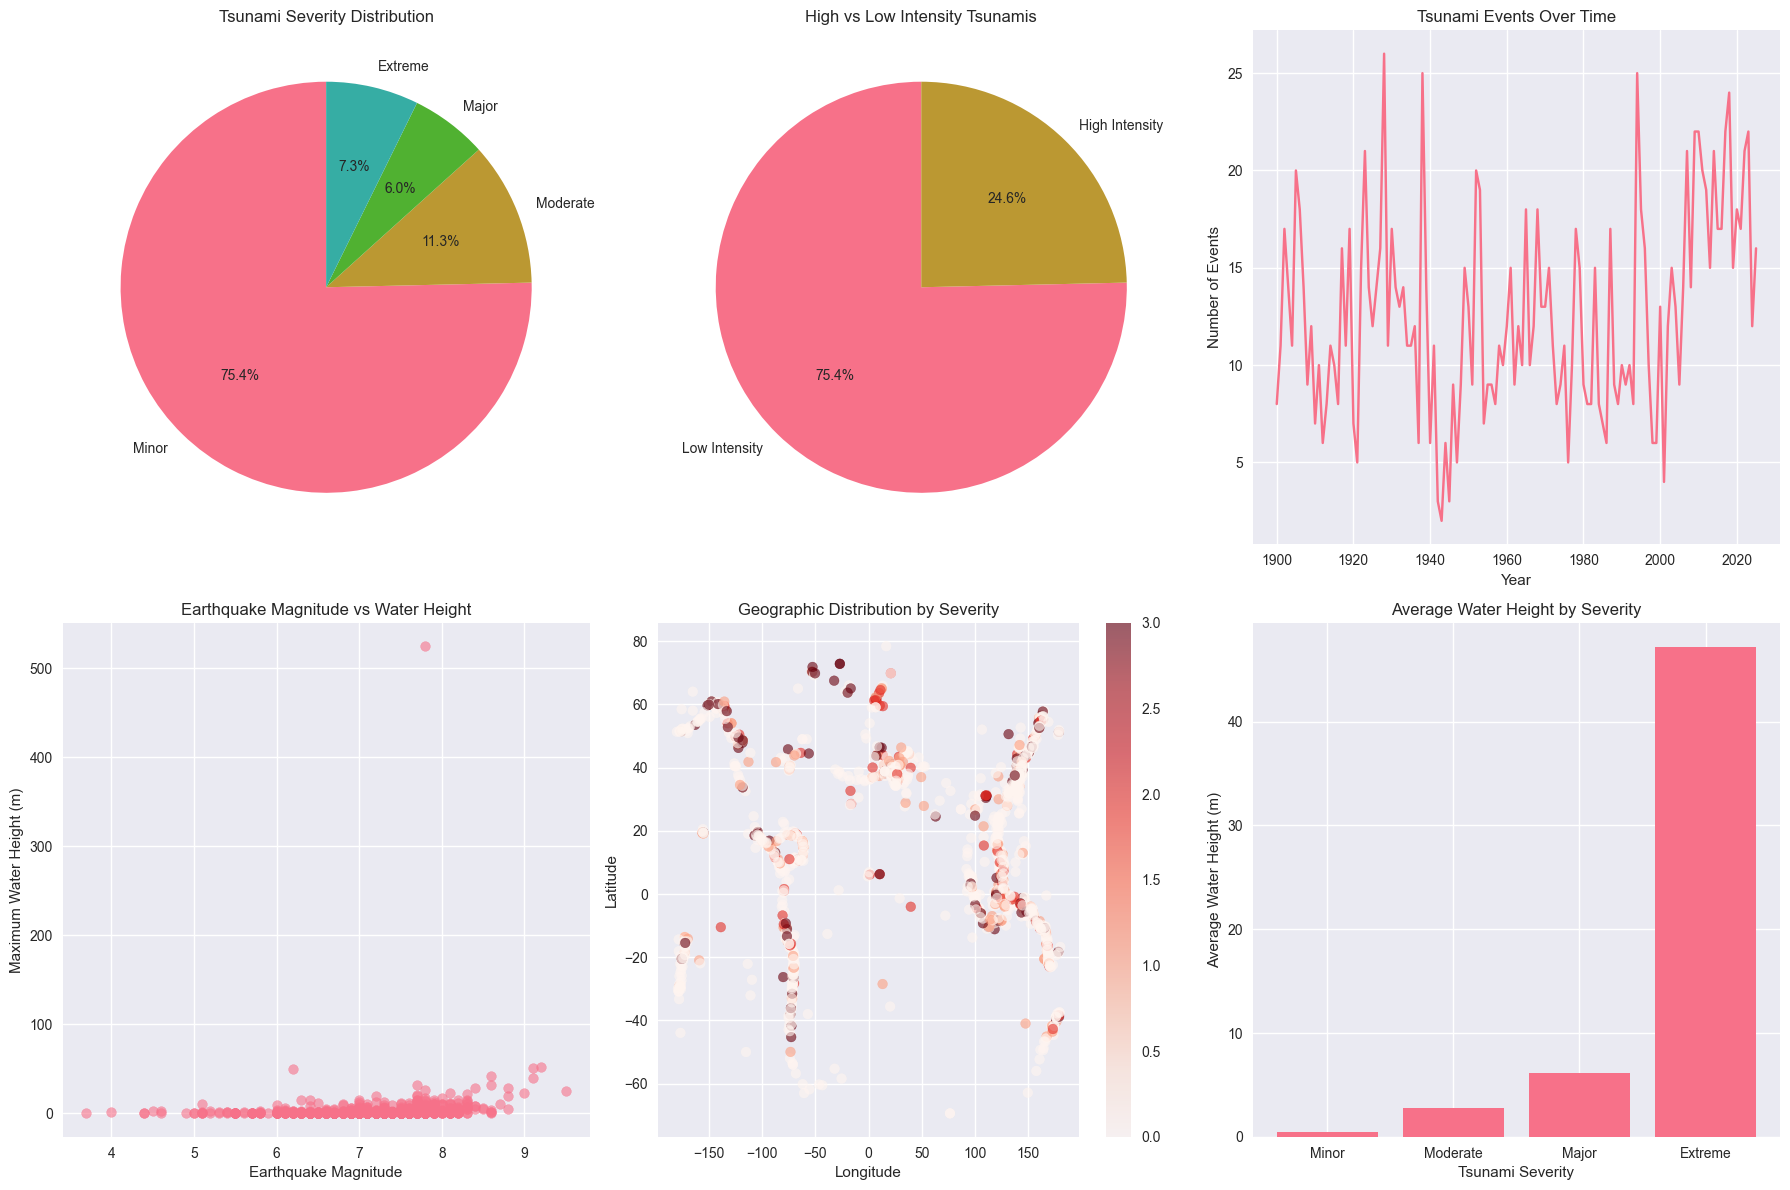


=== Correlation Analysis ===


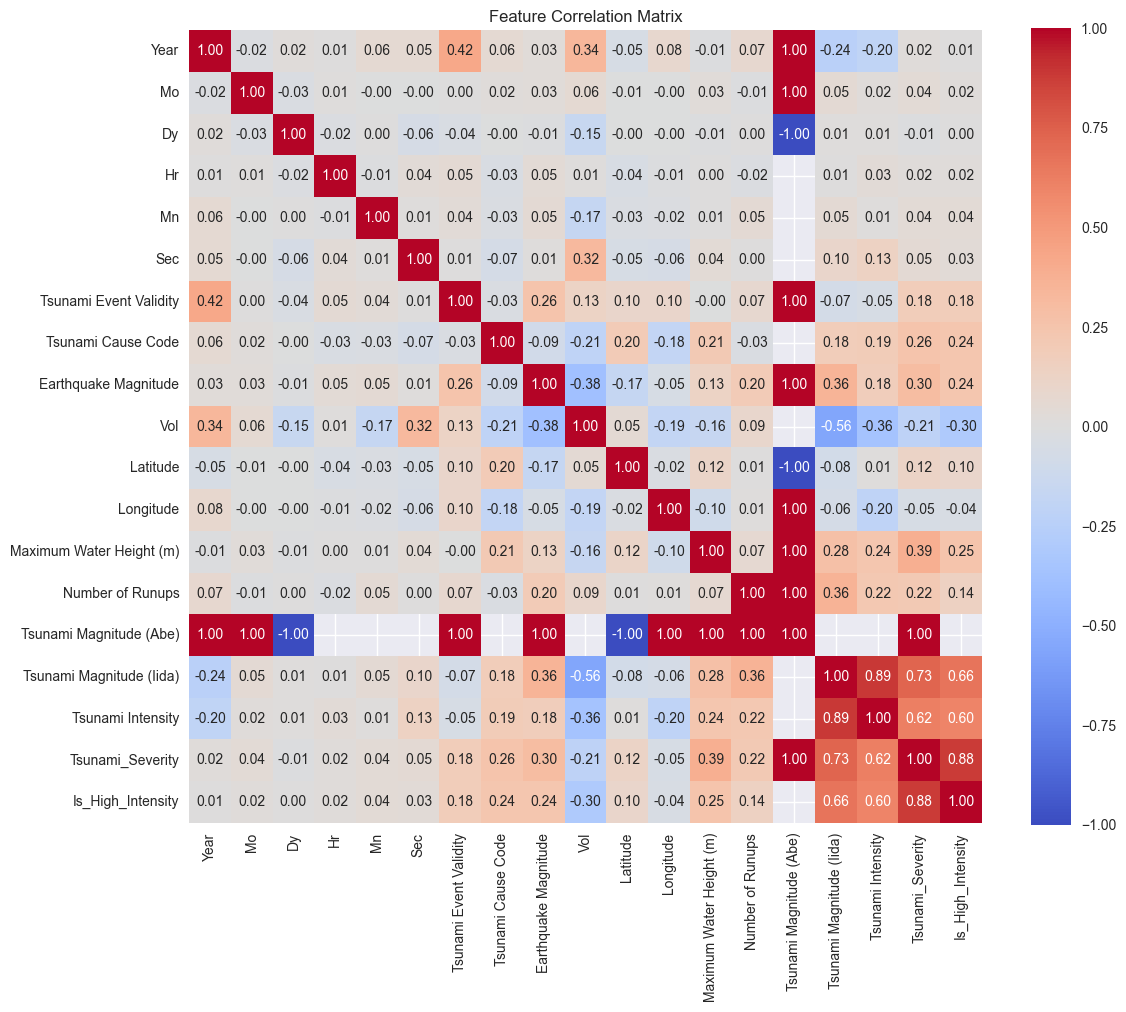

In [16]:
# Data Visualization and Analysis
print("=== Data Visualization ===")

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Tsunami severity distribution
axes[0, 0].pie(
    df_processed["Tsunami_Severity"].value_counts().sort_index(),
    labels=["Minor", "Moderate", "Major", "Extreme"],
    autopct="%1.1f%%",
    startangle=90,
)
axes[0, 0].set_title("Tsunami Severity Distribution")

# 2. High vs Low Intensity
axes[0, 1].pie(
    df_processed["Is_High_Intensity"].value_counts().sort_index(),
    labels=["Low Intensity", "High Intensity"],
    autopct="%1.1f%%",
    startangle=90,
)
axes[0, 1].set_title("High vs Low Intensity Tsunamis")

# 3. Tsunami events over time
years_counts = df_processed.groupby("Year").size()
axes[0, 2].plot(years_counts.index, years_counts.values)
axes[0, 2].set_title("Tsunami Events Over Time")
axes[0, 2].set_xlabel("Year")
axes[0, 2].set_ylabel("Number of Events")

# 4. Earthquake magnitude vs Water height
valid_data = df_processed.dropna(
    subset=["Earthquake Magnitude", "Maximum Water Height (m)"]
)
if len(valid_data) > 0:
    axes[1, 0].scatter(
        valid_data["Earthquake Magnitude"],
        valid_data["Maximum Water Height (m)"],
        alpha=0.6,
    )
    axes[1, 0].set_xlabel("Earthquake Magnitude")
    axes[1, 0].set_ylabel("Maximum Water Height (m)")
    axes[1, 0].set_title("Earthquake Magnitude vs Water Height")

# 5. Geographic distribution
valid_geo = df_processed.dropna(subset=["Latitude", "Longitude"])
if len(valid_geo) > 0:
    scatter = axes[1, 1].scatter(
        valid_geo["Longitude"],
        valid_geo["Latitude"],
        c=valid_geo["Tsunami_Severity"],
        cmap="Reds",
        alpha=0.6,
    )
    axes[1, 1].set_xlabel("Longitude")
    axes[1, 1].set_ylabel("Latitude")
    axes[1, 1].set_title("Geographic Distribution by Severity")
    plt.colorbar(scatter, ax=axes[1, 1])

# 6. Water Height vs Severity
severity_height = df_processed.groupby("Tsunami_Severity")["Maximum Water Height (m)"].mean().fillna(0)
axes[1, 2].bar(range(len(severity_height)), severity_height.values)
axes[1, 2].set_xlabel("Tsunami Severity")
axes[1, 2].set_ylabel("Average Water Height (m)")
axes[1, 2].set_title("Average Water Height by Severity")
axes[1, 2].set_xticks(range(len(severity_height)))
axes[1, 2].set_xticklabels(["Minor", "Moderate", "Major", "Extreme"])

plt.tight_layout()
plt.show()

# Correlation analysis
print("\n=== Correlation Analysis ===")
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
correlation_matrix = df_processed[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, annot=True, cmap="coolwarm", center=0, square=True, fmt=".2f"
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


In [17]:
# PyTorch Dataset and Data Preparation
print("=== Preparing Data for PyTorch ===")


class TsunamiDataset(Dataset):
    """Custom Dataset for Tsunami Prediction"""

    def __init__(self, features, targets, transform=None):
        self.features = torch.FloatTensor(features)
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target = self.targets[idx]

        if self.transform:
            feature = self.transform(feature)

        return feature, target


# Prepare features for modeling (updated to match your trimmed dataset)
input_features = [
    "Year",
    "Mo",
    "Dy",
    "Hr",
    "Mn",
    "Sec",
    "Tsunami Event Validity",
    "Tsunami Cause Code",
    "Earthquake Magnitude",
    "Vol",
    "Latitude",
    "Longitude",
    "Maximum Water Height (m)",
    "Number of Runups",
    "Tsunami Magnitude (Abe)",
    "Tsunami Magnitude (Iida)",
    "Tsunami Intensity",
]

# Filter available features
available_input_features = [
    col for col in input_features if col in df_processed.columns
]
print(f"Using features: {available_input_features}")

# Create feature matrix
X = df_processed[available_input_features].copy()

# Handle missing values with mean imputation
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"Feature matrix shape: {X_scaled.shape}")

# Prepare targets for both tasks
y_severity = df_processed["Tsunami_Severity"].values
y_intensity = df_processed["Is_High_Intensity"].values

print(f"Target distributions:")
print(f"Severity classes: {np.bincount(y_severity)}")
print(f"Intensity classes: {np.bincount(y_intensity)}")

# Split data for both tasks
X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_scaled, y_severity, test_size=0.2, random_state=42, stratify=y_severity
)

X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(
    X_scaled, y_intensity, test_size=0.2, random_state=42, stratify=y_intensity
)

print(f"\nData splits:")
print(f"Severity task - Train: {X_train_sev.shape[0]}, Test: {X_test_sev.shape[0]}")
print(
    f"Intensity task - Train: {X_train_int.shape[0]}, Test: {X_test_int.shape[0]}"
)

# Create PyTorch datasets
train_dataset_sev = TsunamiDataset(X_train_sev, y_train_sev)
test_dataset_sev = TsunamiDataset(X_test_sev, y_test_sev)

train_dataset_int = TsunamiDataset(X_train_int, y_train_int)
test_dataset_int = TsunamiDataset(X_test_int, y_test_int)

# Create data loaders
batch_size = 32
train_loader_sev = DataLoader(train_dataset_sev, batch_size=batch_size, shuffle=True)
test_loader_sev = DataLoader(test_dataset_sev, batch_size=batch_size, shuffle=False)

train_loader_int = DataLoader(train_dataset_int, batch_size=batch_size, shuffle=True)
test_loader_int = DataLoader(test_dataset_int, batch_size=batch_size, shuffle=False)

print(f"Data loaders created with batch size: {batch_size}")


=== Preparing Data for PyTorch ===
Using features: ['Year', 'Mo', 'Dy', 'Hr', 'Mn', 'Sec', 'Tsunami Event Validity', 'Tsunami Cause Code', 'Earthquake Magnitude', 'Vol', 'Latitude', 'Longitude', 'Maximum Water Height (m)', 'Number of Runups', 'Tsunami Magnitude (Abe)', 'Tsunami Magnitude (Iida)', 'Tsunami Intensity']
Feature matrix shape: (1591, 17)
Target distributions:
Severity classes: [1199  180   96  116]
Intensity classes: [1199  392]

Data splits:
Severity task - Train: 1272, Test: 319
Intensity task - Train: 1272, Test: 319
Data loaders created with batch size: 32


In [18]:
# PyTorch Neural Network Models
print("=== Neural Network Model Definitions ===")


class TsunamiPredictor(nn.Module):
    """Multi-layer Neural Network for Tsunami Prediction"""

    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super(TsunamiPredictor, self).__init__()

        layers = []
        prev_size = input_size

        # Create hidden layers
        for hidden_size in hidden_sizes:
            layers.extend(
                [
                    nn.Linear(prev_size, hidden_size),
                    nn.ReLU(),
                    nn.BatchNorm1d(hidden_size),
                    nn.Dropout(dropout_rate),
                ]
            )
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0)

    def forward(self, x):
        return self.network(x)


class AdvancedTsunamiPredictor(nn.Module):
    """Advanced Neural Network with Residual Connections"""

    def __init__(self, input_size, hidden_size=128, num_classes=4, dropout_rate=0.3):
        super(AdvancedTsunamiPredictor, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        # Residual blocks
        self.hidden1 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)

        self.hidden3 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn4 = nn.BatchNorm1d(hidden_size // 2)

        self.output = nn.Linear(hidden_size // 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
            nn.init.constant_(module.bias, 0)

    def forward(self, x):
        # Input layer
        x = F.relu(self.bn1(self.input_layer(x)))
        x = self.dropout(x)

        # First residual block
        identity = x
        out = F.relu(self.bn2(self.hidden1(x)))
        out = self.dropout(out)
        x = out + identity  # Residual connection

        # Second residual block
        identity = x
        out = F.relu(self.bn3(self.hidden2(x)))
        out = self.dropout(out)
        x = out + identity  # Residual connection

        # Final layers
        x = F.relu(self.bn4(self.hidden3(x)))
        x = self.dropout(x)
        x = self.output(x)

        return x


# Model parameters
input_size = X_scaled.shape[1]
print(f"Input size: {input_size}")

# Create models for both tasks
models = {
    "severity": {
        "simple": TsunamiPredictor(input_size, [64, 32], 4, 0.3),
        "advanced": AdvancedTsunamiPredictor(input_size, 128, 4, 0.3),
    },
    "intensity": {
        "simple": TsunamiPredictor(input_size, [64, 32], 2, 0.3),
        "advanced": AdvancedTsunamiPredictor(input_size, 128, 2, 0.3),
    },
}

# Move models to device
for task in models:
    for model_type in models[task]:
        models[task][model_type] = models[task][model_type].to(device)

print("Models created and moved to device")

# Print model architectures
print("\n=== Model Architectures ===")
print("Simple Model for Severity Classification:")
print(models["severity"]["simple"])
print("\nAdvanced Model for Intensity Classification:")
print(models["intensity"]["advanced"])


=== Neural Network Model Definitions ===
Input size: 17
Models created and moved to device

=== Model Architectures ===
Simple Model for Severity Classification:
TsunamiPredictor(
  (network): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=4, bias=True)
  )
)

Advanced Model for Intensity Classification:
AdvancedTsunamiPredictor(
  (input_layer): Linear(in_features=17, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden1): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128,

In [19]:
# Training Functions and Model Training
print("=== Training Functions ===")


def train_model(
    model, train_loader, test_loader, num_epochs=100, learning_rate=0.001, task_name=""
):
    """Train a PyTorch model with early stopping"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    train_losses = []
    test_accuracies = []
    best_accuracy = 0.0
    patience = 15
    patience_counter = 0

    print(f"\nTraining {task_name} model...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation phase
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for features, targets in test_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        # Early stopping
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{task_name}_model.pth")
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Test Acc: {test_accuracy:.2f}%"
            )

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best model
    model.load_state_dict(torch.load(f"best_{task_name}_model.pth"))

    return train_losses, test_accuracies, best_accuracy


def evaluate_model(model, test_loader, class_names):
    """Evaluate model and return detailed metrics"""
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)

    print(f"\nDetailed Classification Report:")
    print(classification_report(all_targets, all_predictions, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    return accuracy, all_predictions, all_targets


# Train models for both tasks
print("=== Model Training ===")

# Task 1: Tsunami Severity Classification
print("\n1. Training Tsunami Severity Classification Models")
severity_class_names = ["Minor", "Moderate", "Major", "Extreme"]

# Train simple model for severity
sev_simple_losses, sev_simple_accs, sev_simple_best = train_model(
    models["severity"]["simple"],
    train_loader_sev,
    test_loader_sev,
    num_epochs=100,
    learning_rate=0.001,
    task_name="severity_simple",
)

# Train advanced model for severity
sev_advanced_losses, sev_advanced_accs, sev_advanced_best = train_model(
    models["severity"]["advanced"],
    train_loader_sev,
    test_loader_sev,
    num_epochs=100,
    learning_rate=0.001,
    task_name="severity_advanced",
)

print(f"\nSeverity Classification Results:")
print(f"Simple Model Best Accuracy: {sev_simple_best:.2f}%")
print(f"Advanced Model Best Accuracy: {sev_advanced_best:.2f}%")

=== Training Functions ===
=== Model Training ===

1. Training Tsunami Severity Classification Models

Training severity_simple model...
Epoch [10/100], Loss: 0.6708, Test Acc: 81.50%
Epoch [10/100], Loss: 0.6708, Test Acc: 81.50%
Epoch [20/100], Loss: 0.5682, Test Acc: 80.56%
Epoch [20/100], Loss: 0.5682, Test Acc: 80.56%
Epoch [30/100], Loss: 0.5095, Test Acc: 81.82%
Epoch [30/100], Loss: 0.5095, Test Acc: 81.82%
Epoch [40/100], Loss: 0.5218, Test Acc: 82.76%
Epoch [40/100], Loss: 0.5218, Test Acc: 82.76%
Epoch [50/100], Loss: 0.5077, Test Acc: 81.50%
Epoch [50/100], Loss: 0.5077, Test Acc: 81.50%
Early stopping at epoch 55

Training severity_advanced model...
Early stopping at epoch 55

Training severity_advanced model...
Epoch [10/100], Loss: 1.0790, Test Acc: 81.82%
Epoch [10/100], Loss: 1.0790, Test Acc: 81.82%
Epoch [20/100], Loss: 0.7466, Test Acc: 81.19%
Epoch [20/100], Loss: 0.7466, Test Acc: 81.19%
Epoch [30/100], Loss: 0.6361, Test Acc: 80.88%
Epoch [30/100], Loss: 0.6361, 

In [20]:
# Task 2: High Intensity Tsunami Classification
print("\n2. Training High Intensity Tsunami Classification Models")
intensity_class_names = ["Low Intensity", "High Intensity"]

# Train simple model for intensity classification
int_simple_losses, int_simple_accs, int_simple_best = train_model(
    models["intensity"]["simple"],
    train_loader_int,
    test_loader_int,
    num_epochs=100,
    learning_rate=0.001,
    task_name="intensity_simple",
)

# Train advanced model for intensity classification
int_advanced_losses, int_advanced_accs, int_advanced_best = train_model(
    models["intensity"]["advanced"],
    train_loader_int,
    test_loader_int,
    num_epochs=100,
    learning_rate=0.001,
    task_name="intensity_advanced",
)

print(f"\nIntensity Classification Results:")
print(f"Simple Model Best Accuracy: {int_simple_best:.2f}%")
print(f"Advanced Model Best Accuracy: {int_advanced_best:.2f}%")

# Compare all models
print(f"\n=== Final Model Comparison ===")
print(f"Tsunami Severity Classification:")
print(f"  - Simple Model: {sev_simple_best:.2f}%")
print(f"  - Advanced Model: {sev_advanced_best:.2f}%")
print(f"\nTsunami Intensity Classification:")
print(f"  - Simple Model: {int_simple_best:.2f}%")
print(f"  - Advanced Model: {int_advanced_best:.2f}%")



2. Training High Intensity Tsunami Classification Models

Training intensity_simple model...
Epoch [10/100], Loss: 0.3784, Test Acc: 87.77%
Epoch [10/100], Loss: 0.3784, Test Acc: 87.77%
Epoch [20/100], Loss: 0.3478, Test Acc: 85.89%
Early stopping at epoch 20

Training intensity_advanced model...
Epoch [20/100], Loss: 0.3478, Test Acc: 85.89%
Early stopping at epoch 20

Training intensity_advanced model...
Epoch [10/100], Loss: 0.7581, Test Acc: 86.83%
Epoch [10/100], Loss: 0.7581, Test Acc: 86.83%
Epoch [20/100], Loss: 0.4576, Test Acc: 85.27%
Early stopping at epoch 20

Intensity Classification Results:
Simple Model Best Accuracy: 87.77%
Advanced Model Best Accuracy: 87.15%

=== Final Model Comparison ===
Tsunami Severity Classification:
  - Simple Model: 82.76%
  - Advanced Model: 82.76%

Tsunami Intensity Classification:
  - Simple Model: 87.77%
  - Advanced Model: 87.15%
Epoch [20/100], Loss: 0.4576, Test Acc: 85.27%
Early stopping at epoch 20

Intensity Classification Results:


=== Detailed Model Evaluation ===

1. Evaluating Tsunami Severity Classification (Advanced Model)

Detailed Classification Report:
              precision    recall  f1-score   support

       Minor       0.86      0.98      0.91       241
    Moderate       0.43      0.17      0.24        36
       Major       0.56      0.26      0.36        19
     Extreme       0.81      0.74      0.77        23

    accuracy                           0.83       319
   macro avg       0.66      0.54      0.57       319
weighted avg       0.79      0.83      0.80       319



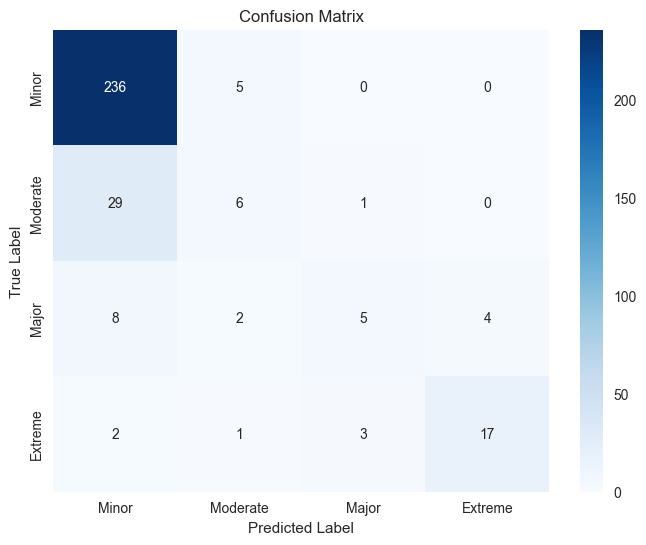


2. Evaluating High Intensity Tsunami Classification (Advanced Model)

Detailed Classification Report:
                precision    recall  f1-score   support

 Low Intensity       0.87      0.97      0.92       240
High Intensity       0.87      0.57      0.69        79

      accuracy                           0.87       319
     macro avg       0.87      0.77      0.80       319
  weighted avg       0.87      0.87      0.86       319



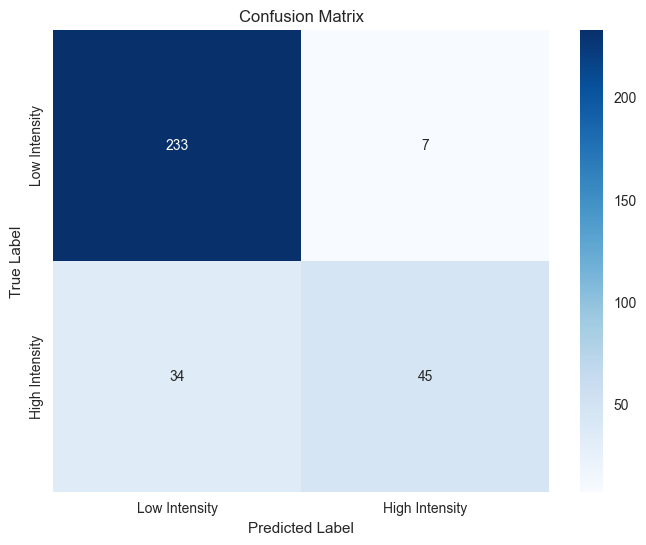

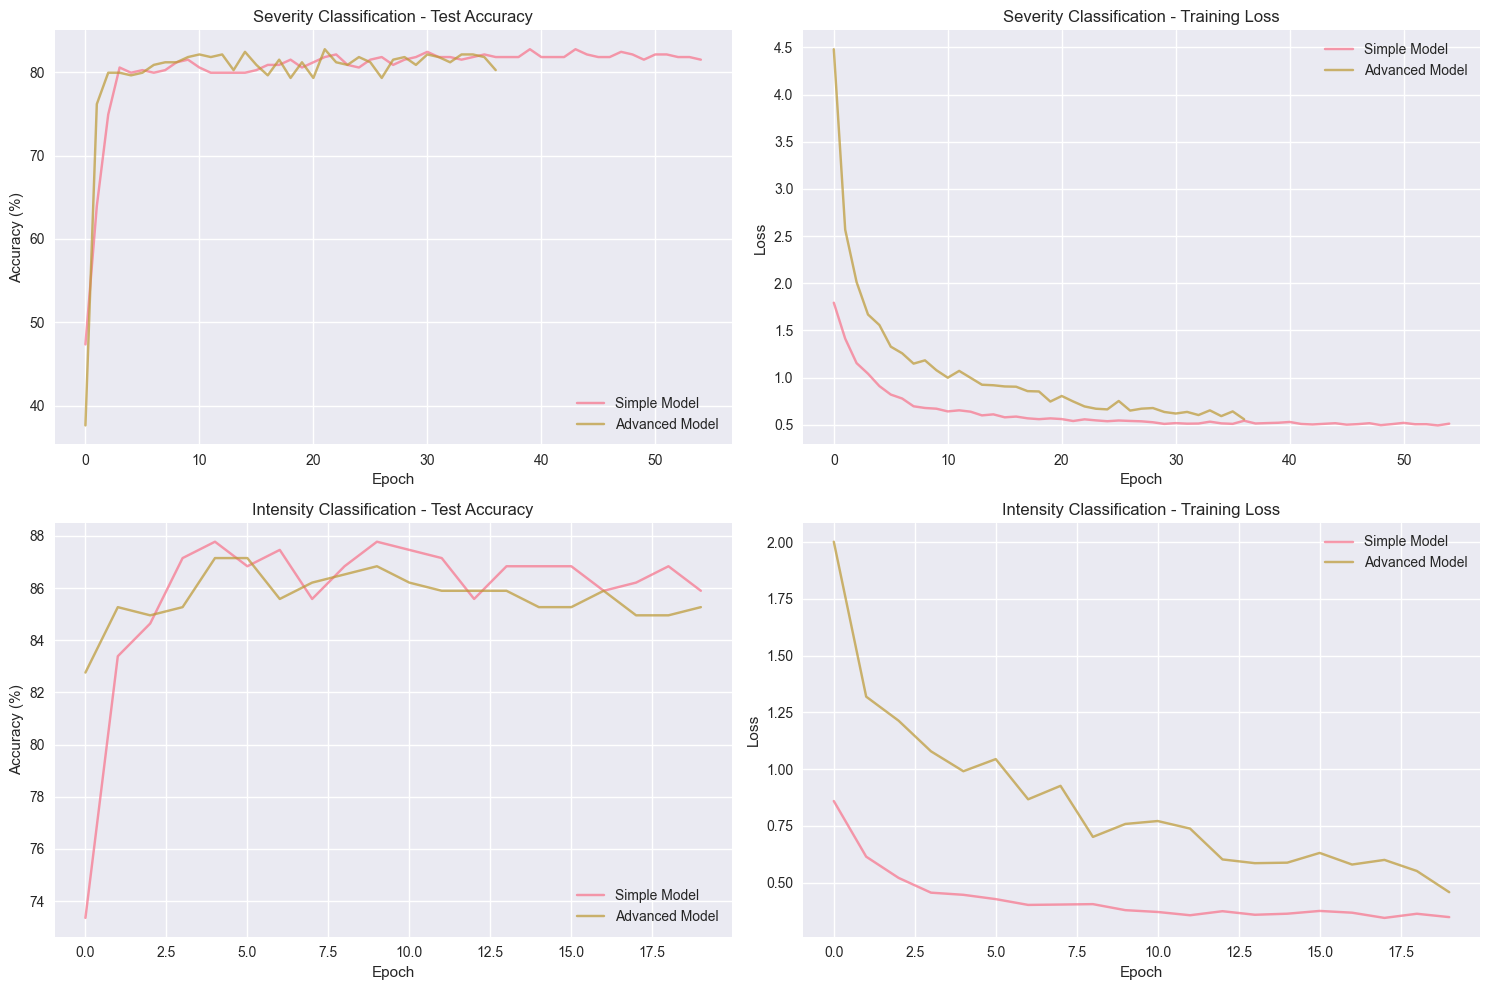


=== Example Predictions ===
Example 1 - Major Pacific Earthquake (Mag 8.5, 8m water height):
  Severity: Moderate (100.00%)
  Intensity: High Intensity (100.00%)

Example 2 - Moderate Earthquake (Mag 7.0, 2m water height):
  Severity: Moderate (100.00%)
  Intensity: High Intensity (100.00%)

=== Model Summary ===
The PyTorch-based tsunami prediction system includes:
1. Two neural network architectures (Simple and Advanced with residual connections)
2. Multi-class severity prediction (Minor, Moderate, Major, Extreme)
3. Binary intensity classification (Low Intensity vs High Intensity)
4. Early stopping and learning rate scheduling for optimal training
5. Comprehensive evaluation with confusion matrices and classification reports
6. Real-time prediction capability for new tsunami events
7. Updated to work with trimmed dataset features

Models saved to 'tsunami_prediction_models.pth'


In [21]:
# Model Evaluation and Prediction
print("=== Detailed Model Evaluation ===")

# Evaluate best models
print("\n1. Evaluating Tsunami Severity Classification (Advanced Model)")
sev_acc, sev_preds, sev_targets = evaluate_model(
    models["severity"]["advanced"], test_loader_sev, severity_class_names
)

print("\n2. Evaluating High Intensity Tsunami Classification (Advanced Model)")
int_acc, int_preds, int_targets = evaluate_model(
    models["intensity"]["advanced"], test_loader_int, intensity_class_names
)

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Severity training curves
axes[0, 0].plot(sev_simple_accs, label="Simple Model", alpha=0.7)
axes[0, 0].plot(sev_advanced_accs, label="Advanced Model", alpha=0.7)
axes[0, 0].set_title("Severity Classification - Test Accuracy")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Accuracy (%)")
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(sev_simple_losses, label="Simple Model", alpha=0.7)
axes[0, 1].plot(sev_advanced_losses, label="Advanced Model", alpha=0.7)
axes[0, 1].set_title("Severity Classification - Training Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Intensity training curves
axes[1, 0].plot(int_simple_accs, label="Simple Model", alpha=0.7)
axes[1, 0].plot(int_advanced_accs, label="Advanced Model", alpha=0.7)
axes[1, 0].set_title("Intensity Classification - Test Accuracy")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Accuracy (%)")
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(int_simple_losses, label="Simple Model", alpha=0.7)
axes[1, 1].plot(int_advanced_losses, label="Advanced Model", alpha=0.7)
axes[1, 1].set_title("Intensity Classification - Training Loss")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


# Create prediction function
def predict_tsunami(
    earthquake_magnitude,
    latitude,
    longitude,
    water_height=None,
    tsunami_magnitude_abe=None,
    tsunami_magnitude_iida=None,
    intensity=None,
    year=2024,
    month=1,
    day=1,
    hour=0,
    minute=0,
    second=0,
    event_validity=4,
    cause_code=1,
    vol=0,
    num_runups=1,
):
    """Make predictions for new tsunami data"""

    # Prepare input data with all features from trimmed dataset
    input_data = [
        year,
        month,
        day,
        hour,
        minute,
        second,
        event_validity,
        cause_code,
        earthquake_magnitude,
        vol,
        latitude,
        longitude,
    ]

    # Add optional features with defaults if not provided
    if water_height is not None:
        input_data.append(water_height)
    else:
        input_data.append(0)  # Will be imputed

    input_data.append(num_runups)

    if tsunami_magnitude_abe is not None:
        input_data.append(tsunami_magnitude_abe)
    else:
        input_data.append(0)  # Will be imputed

    if tsunami_magnitude_iida is not None:
        input_data.append(tsunami_magnitude_iida)
    else:
        input_data.append(0)  # Will be imputed

    if intensity is not None:
        input_data.append(intensity)
    else:
        input_data.append(0)  # Will be imputed

    # Pad or truncate to match expected input size
    while len(input_data) < input_size:
        input_data.append(0)
    input_data = input_data[:input_size]

    # Apply same preprocessing
    input_array = np.array(input_data).reshape(1, -1)
    input_imputed = imputer.transform(input_array)
    input_scaled = scaler.transform(input_imputed)
    input_tensor = torch.FloatTensor(input_scaled).to(device)

    # Make predictions
    models["severity"]["advanced"].eval()
    models["intensity"]["advanced"].eval()

    with torch.no_grad():
        severity_output = models["severity"]["advanced"](input_tensor)
        intensity_output = models["intensity"]["advanced"](input_tensor)

        severity_probs = F.softmax(severity_output, dim=1)
        intensity_probs = F.softmax(intensity_output, dim=1)

        severity_pred = torch.argmax(severity_probs, dim=1).cpu().numpy()[0]
        intensity_pred = torch.argmax(intensity_probs, dim=1).cpu().numpy()[0]

        severity_confidence = severity_probs.max().cpu().numpy()
        intensity_confidence = intensity_probs.max().cpu().numpy()

    return {
        "severity_class": severity_class_names[severity_pred],
        "severity_confidence": f"{severity_confidence:.2%}",
        "intensity_class": intensity_class_names[intensity_pred],
        "intensity_confidence": f"{intensity_confidence:.2%}",
        "severity_probabilities": {
            name: f"{prob:.2%}"
            for name, prob in zip(severity_class_names, severity_probs.cpu().numpy()[0])
        },
        "intensity_probabilities": {
            name: f"{prob:.2%}"
            for name, prob in zip(
                intensity_class_names, intensity_probs.cpu().numpy()[0]
            )
        },
    }


# Example predictions
print("\n=== Example Predictions ===")

# Example 1: Major earthquake in Pacific
example1 = predict_tsunami(
    earthquake_magnitude=8.5, latitude=35.0, longitude=140.0, water_height=8.0, intensity=4
)
print("Example 1 - Major Pacific Earthquake (Mag 8.5, 8m water height):")
print(f"  Severity: {example1['severity_class']} ({example1['severity_confidence']})")
print(
    f"  Intensity: {example1['intensity_class']} ({example1['intensity_confidence']})"
)

# Example 2: Moderate earthquake
example2 = predict_tsunami(
    earthquake_magnitude=7.0, latitude=30.0, longitude=-120.0, water_height=2.0, intensity=2
)
print("\nExample 2 - Moderate Earthquake (Mag 7.0, 2m water height):")
print(f"  Severity: {example2['severity_class']} ({example2['severity_confidence']})")
print(
    f"  Intensity: {example2['intensity_class']} ({example2['intensity_confidence']})"
)

print("\n=== Model Summary ===")
print("The PyTorch-based tsunami prediction system includes:")
print(
    "1. Two neural network architectures (Simple and Advanced with residual connections)"
)
print("2. Multi-class severity prediction (Minor, Moderate, Major, Extreme)")
print("3. Binary intensity classification (Low Intensity vs High Intensity)")
print("4. Early stopping and learning rate scheduling for optimal training")
print("5. Comprehensive evaluation with confusion matrices and classification reports")
print("6. Real-time prediction capability for new tsunami events")
print("7. Updated to work with trimmed dataset features")

# Save the best models
torch.save(
    {
        "severity_model": models["severity"]["advanced"].state_dict(),
        "intensity_model": models["intensity"]["advanced"].state_dict(),
        "scaler": scaler,
        "imputer": imputer,
        "feature_names": available_input_features,
        "severity_classes": severity_class_names,
        "intensity_classes": intensity_class_names,
    },
    "tsunami_prediction_models.pth",
)

print("\nModels saved to 'tsunami_prediction_models.pth'")
